In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime

In [2]:
sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(15,8)})

In [3]:
# read factors
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
factors_returns = pd.read_csv('factors_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)
strategy_returns = pd.read_csv('strategy_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)

In [4]:
def freward(weights):
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    tracking_error =  (pred_returns.values - strategy_returns.iloc[:,0].values)
    return -np.sqrt(np.mean(tracking_error**2))

In [5]:
def freward_teacher(weights):
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    tracking_error =  (pred_returns.values - strategy_returns.iloc[:,0].values
        ) * np.sqrt(250) * np.sqrt(weights.shape[1]+1)
    turn_over = 0.0020 * 365 * ((weights - weights.shift(1)).abs().fillna(0).values
        ) / ((weights.index[-1] -weights.index[0]).days) * np.sqrt(
        weights.shape[0] * (weights.shape[1]+1)) 
    error_terms = np.concatenate([tracking_error, turn_over.flatten()], axis=0)
    return -np.sqrt(np.mean(error_terms**2))

In [6]:
strategy_returns.head(10)

,Last Price
Date,
2010-01-04,0.000000
2010-01-05,0.002270
2010-01-06,0.004127
2010-01-07,0.000179
2010-01-08,0.001401
2010-01-11,0.002056
2010-01-12,-0.001762
2010-01-13,-0.000401
2010-01-14,0.001357


In [7]:
def buildPrices(dataframe,base):
    df= pd.DataFrame()
    for name in dataframe.columns:
        df[name+' price']= base * (1 + dataframe[name]).cumprod()
    return df

In [8]:
# read factors
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
factors_returns = pd.read_csv('factors_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)
strategy_returns = pd.read_csv('strategy_returns.csv', index_col=0, 
                      parse_dates=True, date_parser=dateparse)

# create simple random weights (equal weight plus some noise 4% per annum)
data = np.tile( [1/factors_returns.shape[1]] * factors_returns.shape[1], 
               factors_returns.shape[0]).reshape(factors_returns.shape)
weights = pd.DataFrame(index=factors_returns.index, columns = factors_returns.columns, data=data)
weights += np.random.normal(0, 0.04/ np.sqrt(250), weights.shape)
print(strategy_returns)

            Last Price
Date                  
2010-01-04    0.000000
2010-01-05    0.002270
2010-01-06    0.004127
2010-01-07    0.000179
2010-01-08    0.001401
...                ...
2022-02-03   -0.002747
2022-02-04   -0.000319
2022-02-07    0.000347
2022-02-08    0.001770
2022-02-09    0.003407

[3058 rows x 1 columns]


In [9]:
 factors_returns.head()

,Bloomberg Commodities,Dollar Index,EM Bond USD,EU Global Aggregate,EU HY,EU Stoxx 600,Japan Nikkei 225,MSCI EM USD,US Global Aggregate,US HY,US S&P 500
Date,,,,,,,,,,,
2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-05,-0.001329,0.000467,0.004215,0.001062,0.007361,-0.000215,0.002538,0.010706,0.004409,0.002218,0.003119
2010-01-06,0.020527,0.000061,0.000460,-0.000679,0.006578,0.001435,0.004645,0.006396,-0.000904,0.007291,0.000850
2010-01-07,-0.015051,0.005292,-0.000300,0.001803,0.006402,0.000334,-0.004640,-0.007172,-0.000517,0.003488,0.004046
2010-01-08,-0.003042,-0.004810,0.000482,0.000787,0.004789,0.004298,0.010921,0.001963,0.000899,0.003684,0.002880


In [10]:
df = buildPrices(factors_returns,100)

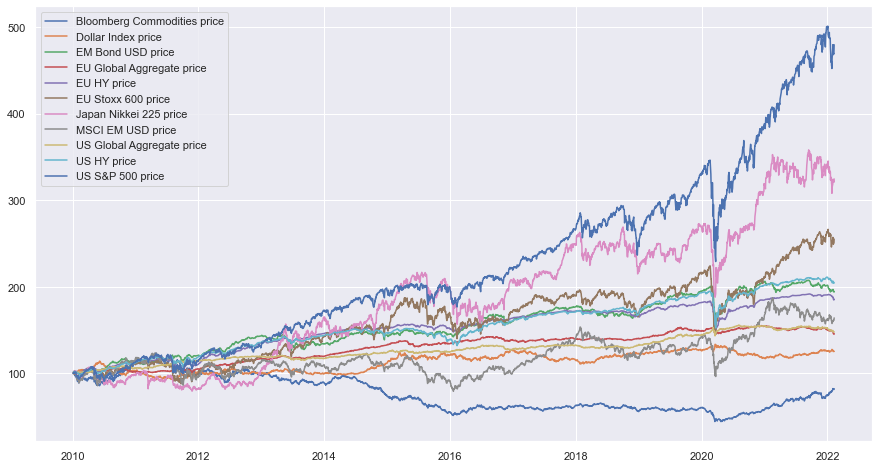

In [11]:
plt.plot(df)
plt.legend(df.columns,loc='upper left')

In [12]:
df['Strategy price']= 100 * (1 + strategy_returns['Last Price']).cumprod()

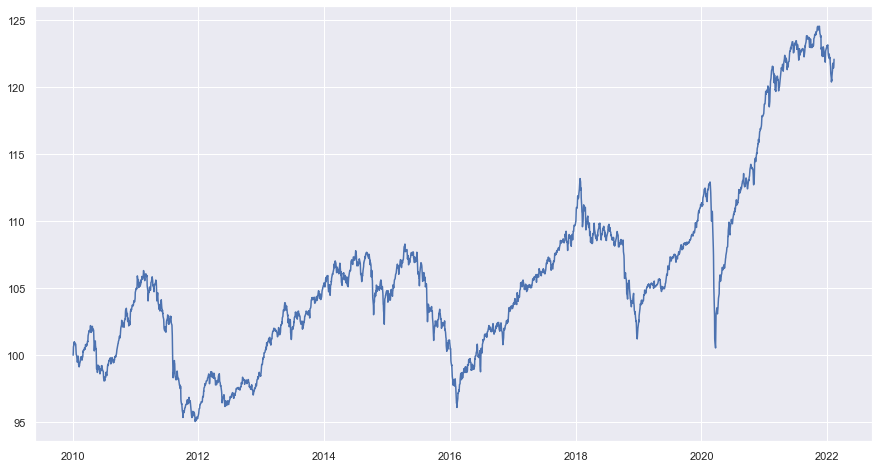

In [13]:
plt.plot(df['Strategy price'])

# DDPG

In [14]:
import sys
import copy
import matplotlib.pyplot as plt
from itertools import count
from datetime import datetime
from envmkt import Decode_v1
from ddpg import DDPGagent
from utils import *

C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
env = Decode_v1(factors_returns=factors_returns,strategy_returns=strategy_returns,random_start=False,window=7)

In [16]:
agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
nb_episodes = 20

In [17]:
rewards = []
avg_rewards = []
best_env = env
best_reward = -100

for episode in range(nb_episodes):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in count():
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        #print(action)
        #print(np.linalg.norm(action))
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state 
        episode_reward += reward 

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            print(f'Env reward is {freward_teacher(env.weights_df)}')
            if freward_teacher(env.weights_df) > best_reward :
                best_env = copy.deepcopy(env)
                best_reward = freward_teacher(env.weights_df)
                print(f'best reward has been set to {best_reward}')
                print('best_env has been changed')
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards))

C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\duzen\anaconda3\envs\torch_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode: 0, reward: -4.52, average _reward: nan 
Env reward is -0.025588443203123874
best reward has been set to -0.025588443203123874
best_env has been changed
episode: 1, reward: -5.88, average _reward: -4.519933964830677 
Env reward is -0.03687252521684327
episode: 2, reward: -6.1, average _reward: -5.200923989020625 
Env reward is -0.03970866312473288
episode: 3, reward: -9.54, average _reward: -5.501739971778993 
Env reward is -0.060074569885780776
episode: 4, reward: -4.86, average _reward: -6.511618608457509 
Env reward is -0.02737222025049537
episode: 5, reward: -4.88, average _reward: -6.181829557981562 
Env reward is -0.027503644561360143
episode: 6, reward: -4.87, average _reward: -5.965102559650462 
Env reward is -0.02729826529865201
episode: 7, reward: -4.85, average _reward: -5.809025739032651 
Env reward is -0.02727141046739291
episode: 8, reward: -4.84, average _reward: -5.689604729551021 
Env reward is -0.0271045825844812
episode: 9, reward: -4.87, average _reward: -5.

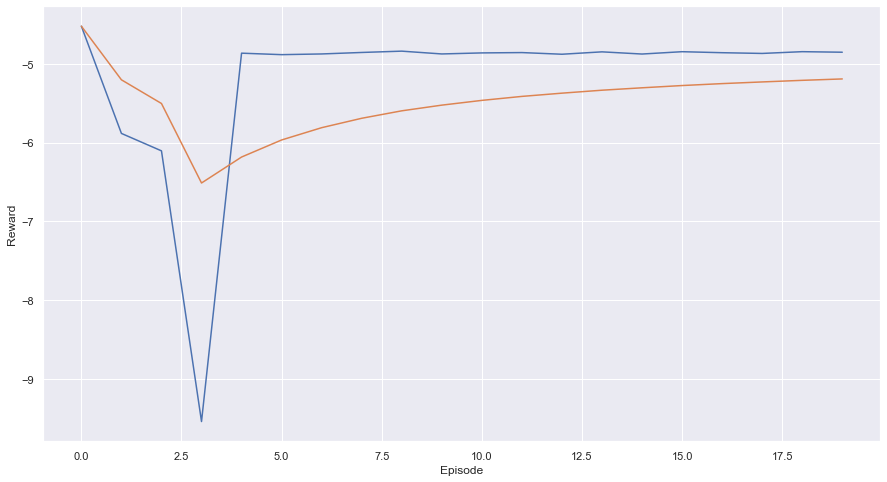

In [18]:
plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [33]:
weights_predicted = best_env.weights_df 

In [34]:
freward_teacher(weights_predicted)

-0.025588443203123874

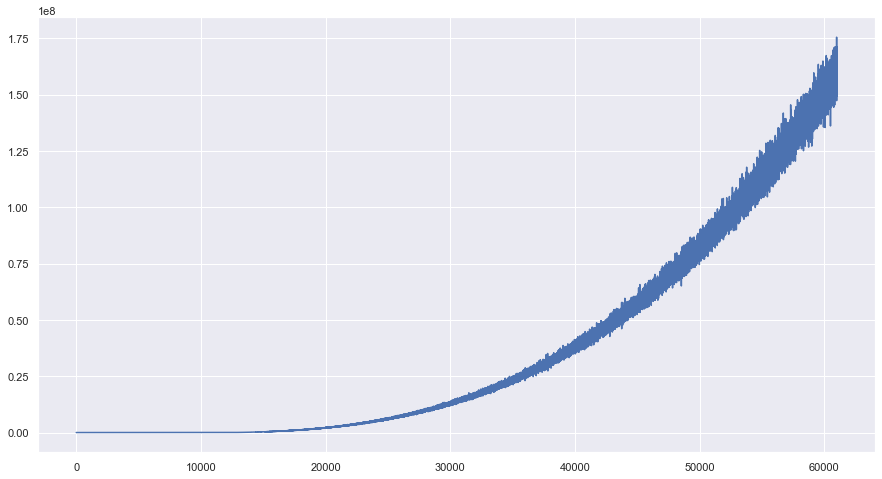

In [21]:
plt.plot(range(len(agent.critic_losses)),agent.critic_losses)
plt.show()

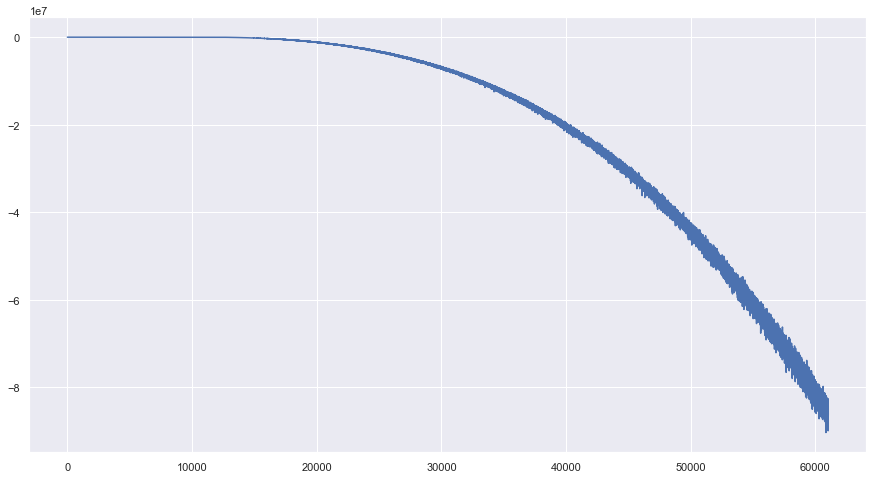

In [22]:
plt.plot(range(len(agent.actor_losses)),agent.actor_losses)
plt.show()

In [23]:
weights_predicted.head(20)

,Bloomberg Commodities,Dollar Index,EM Bond USD,EU Global Aggregate,EU HY,EU Stoxx 600,Japan Nikkei 225,MSCI EM USD,US Global Aggregate,US HY,US S&P 500
Date,,,,,,,,,,,
2010-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-05,0.048845,0.03422,0.040266,0.052356,0.048352,0.019681,0.041045,0.026616,0.030056,0.030977,0.032828
2010-01-06,0.04585,0.037841,0.031582,0.034357,0.032985,0.044423,0.029514,0.031157,0.022504,0.001442,0.037974
2010-01-07,0.040103,0.022688,0.05324,0.01542,0.030058,0.027314,0.046942,0.042788,0.032664,0.030606,0.022613
2010-01-08,0.011272,0.026694,0.032136,0.042368,0.041841,0.02572,0.028654,0.01752,0.016878,0.009582,0.050802
2010-01-11,0.026211,0.025814,0.017782,0.03772,0.013546,0.02727,0.022633,0.031982,0.026016,0.015039,0.031209
2010-01-12,0.035555,0.030948,0.033437,0.023635,0.026054,0.022734,0.027894,0.019895,0.01373,0.028757,0.027406
2010-01-13,0.015153,0.034969,0.021241,0.029867,0.036943,0.031126,0.042979,0.016108,0.03516,0.019743,0.022577
2010-01-14,0.025866,0.027041,0.031326,0.018084,0.038959,0.034308,0.01589,0.043359,0.04981,0.037848,0.029647


In [24]:
pred_returns = pd.DataFrame()
pred_returns['Last Price'] = (1 + (weights_predicted * factors_returns).sum(axis=1)).cumprod().pct_change().fillna(0)

In [25]:
pred_returns.head()

,Last Price
Date,
2010-01-04,0.000000
2010-01-05,0.001221
2010-01-06,0.001574
2010-01-07,-0.000613
2010-01-08,0.000741


In [26]:
df['Agent price']= 100 * (1 + pred_returns['Last Price']).cumprod()

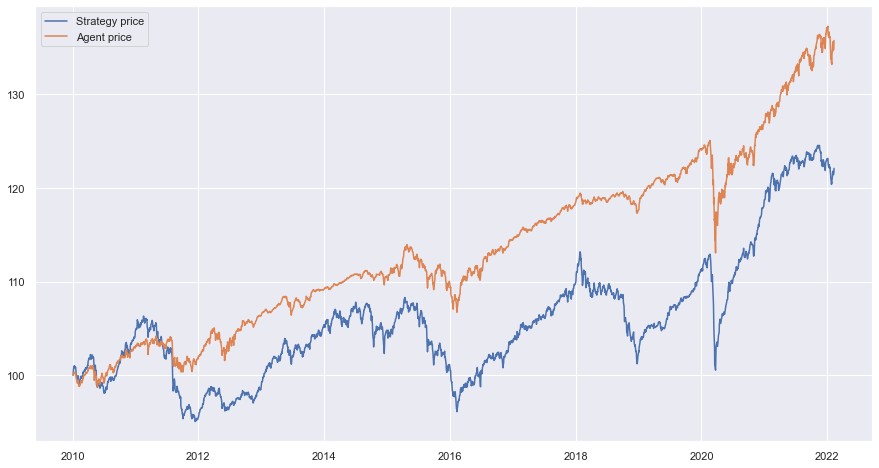

In [27]:
plt.plot(df[['Strategy price','Agent price']])
plt.legend(df[['Strategy price','Agent price']].columns,loc='upper left')

In [28]:
def create_submission(weights, factors_returns):
    # some financial computations
    weight_abs_diff = (weights - weights.shift(1)).abs().fillna(0)
    weight_abs_diff*= 0.0025 * 365 / ((weights.index[-1] - weights.index[0]).days) * np.sqrt(
        weights.shape[0] * (weights.shape[1]+1))
    pred_returns = (1 + (weights * factors_returns).sum(axis=1)).cumprod(
        ).pct_change().fillna(0)
    pred_returns*= np.sqrt(250) * np.sqrt(weights.shape[1]+1)
                    
    # format submission
    submission = pred_returns.to_frame() 
    submission.columns = ['Expected']
    submission.index = ['{:%Y-%m-%d}'.format(x) + '_returns' for x in pred_returns.index]
    
    for col in weight_abs_diff.columns:
        tmp = weight_abs_diff[col].to_frame()
        tmp.columns = ['Expected']
        tmp.index = [ '{:%Y-%m-%d}'.format(x) + '_{:}'.format(col) for x in tmp.index]
        submission = pd.concat([submission, tmp], axis=0)
    submission.index.names = ['Id']
    return submission
                    

In [31]:
submission = create_submission(best_env.weights_df , factors_returns)

In [32]:
submission.to_csv('submission.csv')